In [1]:
import scipy.sparse.linalg as spsplin
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Convergence of CG for different spectrum
n = 1000
A = np.random.randn(n, n)
# A = A.T @ A
Q, _ = np.linalg.qr(A)
A = Q @ np.diag([1, 10] + [100 + i for i in range(n-2)]) @ Q.T
eigvals = np.linalg.eigvalsh(A)

In [31]:
print(min(eigvals), max(eigvals))

1.000000000000953 1097.0000000000016


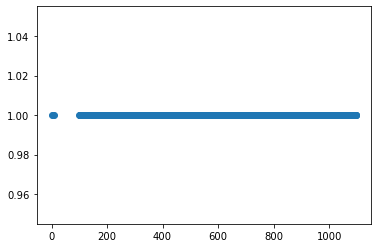

In [32]:
plt.scatter(eigvals, np.ones(n))

In [33]:
q = np.linalg.cond(A)
print(q)
print((q - 1) / (q + 1))
print((np.sqrt(q) - 1) / (np.sqrt(q) + 1))

1097.0000000000516
0.9981785063752278
0.9413850541544568


- Richardson iteration convergence 

$$ \|x_{k+1} - x^* \|_2 \leq C \left(\frac{\kappa - 1}{\kappa+1}\right)^k $$

- Chebyshev iteration convergence

$$ \|x_{k+1} - x^* \|_2 \leq C \left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa}+1}\right)^k $$

In [44]:
rhs = np.random.randn(n)
x0 = np.random.randn(n)

In [76]:
conv_cg = []

def cl_cg(x):
    conv_cg.append(x.copy())
    
x_cg, info = spsplin.cg(A, rhs, callback=cl_cg, x0=x0, tol=1e-6)

In [77]:
np.linalg.norm(A @ x_cg - rhs)

2.504019900942985e-05

In [78]:
def richardson(A, b, tau, x0, tol, max_iter):
    x = x0.copy()
    conv = []
    for i in range(max_iter):
        x = x - tau * (A @ x - b)
        conv.append(x)
        if np.linalg.norm(A @ x - b) < tol:
            break
    return x, conv

In [79]:
x_rich, conv_rich = richardson(A, rhs, 2 / (min(eigvals) + max(eigvals)), x0,
                               1e-6, 1000)
print(np.linalg.norm(A @ x_rich - rhs))

35.52946857894798


Text(0, 0.5, '$||Ax_k - b||_2$')

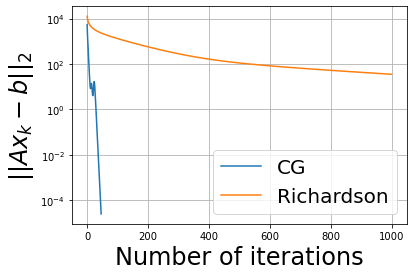

In [80]:
plt.semilogy([np.linalg.norm(A @ x - rhs) for x in conv_cg], label="CG")
plt.semilogy([np.linalg.norm(A @ x - rhs) for x in conv_rich], label="Richardson")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("Number of iterations", fontsize=24)
plt.ylabel("$||Ax_k - b||_2$", fontsize=24)

In [81]:
niters = 256
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
lam_max = max(eigvals)
lam_min = min(eigvals)
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb = [np.linalg.norm(r)]

# Implementation may be non-optimal if number of iterations is not power of two
def good_shuffle(idx):
    if len(idx) == 1:
        return idx
    else:
        new_len = int(np.ceil((len(idx) / 2)))
        new_idx = good_shuffle(idx[:new_len])
        res_perm = []
        perm_count = 0
        for i in new_idx:
            res_perm.append(i)
            perm_count += 1
            if perm_count == len(idx):
                break
            res_perm.append(len(idx) + 1 - i)
            perm_count += 1
            if perm_count == len(idx):
                break
        return res_perm

good_perm = good_shuffle([i for i in range(1, niters+1)])
# good_perm = [i for i in range(niters, 0, -1)]
# good_perm = [i for i in range(niters)]
# good_perm = np.random.permutation([i for i in range(1, niters+1)])

for i in range(niters):
    x = x - 1.0/taus[good_perm[i] - 1] * r
    r = A.dot(x) - rhs
    res_cheb.append(np.linalg.norm(r))

Text(0, 0.5, '$||Ax_k - b||_2$')

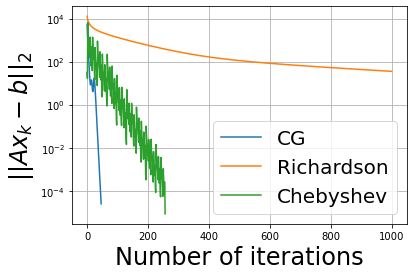

In [82]:
plt.semilogy([np.linalg.norm(A @ x - rhs) for x in conv_cg], label="CG")
plt.semilogy([np.linalg.norm(A @ x - rhs) for x in conv_rich], label="Richardson")
plt.semilogy(res_cheb, label="Chebyshev")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("Number of iterations", fontsize=24)
plt.ylabel("$||Ax_k - b||_2$", fontsize=24)

In [83]:
%timeit np.linalg.solve(A, rhs)
%timeit spsplin.cg(A, rhs)

8.59 ms ± 402 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
10.6 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
